# Feature Selection and Dimensionality Reduction Demo

How to use PCA and mutual information for feature selection and dimensionality reduction on audio features.

> **Note:**
> This notebook expects a file named `batch_features.npy` (or `.json`) in the current directory, containing extracted audio features. If you do not have this file, you can generate it by running the batch extraction script from the command line:
>
> ```powershell
> # From the project root directory
> python -m AFX.cli <your_audio_folder> --config AFX/config.json --output batch_features.npy --format npy
> ```

In [1]:
import numpy as np
import pandas as pd
from AFX.utils.selectors import pca_reducer, mutual_info_selector, correlation_selector

# Load a previously extracted feature set (from batch demo)
df = pd.DataFrame(np.load('batch_features.npy', allow_pickle=True).item()).T.reset_index(drop=True)

# Drop non-numeric columns and missing values
feature_cols = [col for col in df.columns if col not in ['file', 'error']]
df = df.dropna(subset=feature_cols)
X = df[feature_cols].values

In [2]:
# Example: Extract features with original shapes for visualization (if running extraction here)
# config_with_shape = config.copy()
# config_with_shape['preserve_shape'] = True
# features = extract_all_features(signal, sr, config_with_shape)

In [3]:
df.head()

,melspectrogram,mfcc
0,"[-0.23826301526423083, -0.23799505578125993, -...","[-3.299095970639816, 1.2971296488160395, 0.367..."
1,"[-0.2433682847143399, -0.24309124741661775, -0...","[-3.1596178506582278, 1.5900615092728474, 0.46..."
2,"[-0.2136897380718165, -0.21278248815925818, -0...","[-3.359805974533845, 1.112558067664896, 0.2734..."
3,"[-0.33592851162520326, -0.3232470533862623, -0...","[-3.1735152784383236, 1.4950281603274025, -0.3..."
4,"[10.122740803897761, 3.6782751514172167, 1.440...","[-3.294248888487409, 1.3028022091529838, 0.418..."


## Dimensionality Reduction with PCA

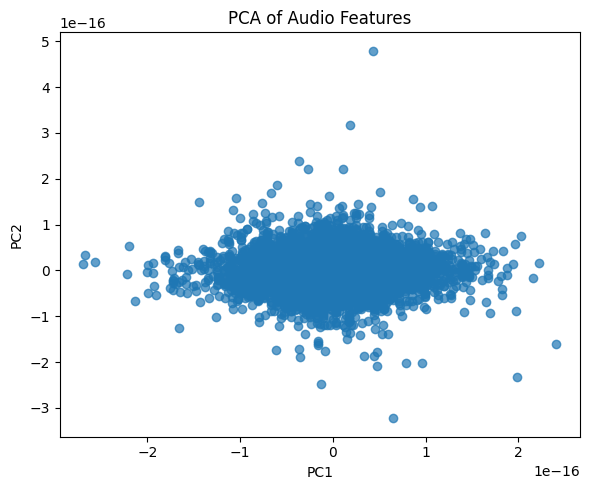

In [4]:
# Reduce to 2 principal components for visualization
#X_pca, pca = pca_reducer({k: df[k].values for k in feature_cols}, n_components=2)

# Flatten features: if a value is a list/array, take its mean; else use as is
flat_features = {}
for k in feature_cols:
    flat_features[k] = df[k].apply(lambda v: np.mean(v) if isinstance(v, (list, np.ndarray)) else v)
X_flat = pd.DataFrame(flat_features).values

X_pca, pca = pca_reducer({k: X_flat[:, i] for i, k in enumerate(feature_cols)}, n_components=2)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Audio Features')
plt.tight_layout()
plt.show()

## Feature Selection with Mutual Information

Suppose we have labels (e.g., class IDs) for supervised selection. Here, we simulate random labels for demonstration.

In [5]:
# Simulate random labels (replace with real labels for the dataset)

y = np.random.randint(0, 2, size=X_flat.shape[0])
selected_idx = mutual_info_selector(X_flat, y, k=5)
selected_features = [feature_cols[i] for i in selected_idx]
print('Top 5 features by mutual information:', selected_features)

Top 5 features by mutual information: ['mfcc', 'melspectrogram']


## Correlation-Based Feature Filtering

In [6]:
selected_corr_idx = correlation_selector(X_flat, threshold=0.9)
selected_corr_features = [feature_cols[i] for i in selected_corr_idx]
print('Features after correlation filtering:', selected_corr_features)

Features after correlation filtering: ['melspectrogram', 'mfcc']


## Experiment: Varying Correlation Thresholds and Using Different Feature Selectors

Different correlation thresholds and compare the results of mutual information and variance threshold selectors.

In [7]:
thresholds = [0.7, 0.8, 0.9, 0.95]
for thresh in thresholds:
    idx = correlation_selector(X_flat, threshold=thresh)
    features = [feature_cols[i] for i in idx]
    print(f'Correlation threshold {thresh}: {len(features)} features selected')

Correlation threshold 0.7: 2 features selected
Correlation threshold 0.8: 2 features selected
Correlation threshold 0.9: 2 features selected
Correlation threshold 0.95: 2 features selected


In [1]:
# # Experiment: Variance threshold selector (remove low-variance features)
# from sklearn.feature_selection import VarianceThreshold

# selector = VarianceThreshold(threshold=0.01)
# X_var = selector.fit_transform(X_flat)
# selected_var_features = [feature_cols[i] for i in selector.get_support(indices=True)]
# print(f'Features selected by variance threshold: {selected_var_features}')

In [ ]:
# Compare mutual information and variance threshold selectors
print('Top 5 features by mutual information:', selected_features)
print('Features selected by variance threshold:', selected_var_features)
common_features = set(selected_features) & set(selected_var_features)
print(f'Common features selected by both: {list(common_features)}')

Top 5 features by mutual information: ['hnr', 'thd', 'pitch', 'chroma_cqt', 'mfcc_delta']
Features selected by variance threshold: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'melspectrogram', 'mfcc', 'pitch', 'thd', 'hnr']
Common features selected by both: ['thd', 'pitch', 'hnr']
